## 1. Librerías

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid',{'grid.color': '.6', 'grid.linestyle': ':'})
# plt.style.use('ggplot')

"""Semilla"""
seed = 42

In [89]:
#Ruta CSV
ruta_csv = Path('Data').resolve().glob('*.csv').__next__()

In [90]:
#Cargamos el DF
df = pd.read_csv(ruta_csv)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.1 Funciones

In [91]:
def metricas(modelo, X_train, X_test, y_train, y_test):
    """
    Calcula y devuelve las métricas de rendimiento para un modelo dado en los conjuntos de entrenamiento y prueba.

    Parámetros:
    - modelo: El modelo de machine learning que se evaluará.
    - X_train: Conjunto de datos de entrenamiento (características).
    - X_test: Conjunto de datos de prueba (características).
    - y_train: Etiquetas verdaderas para el conjunto de entrenamiento.
    - y_test: Etiquetas verdaderas para el conjunto de prueba.

    Retorna:
    - Un df con las métricas de rendimiento: precisión en entrenamiento, precisión en prueba,
      precisión y recall en el conjunto de prueba.
    """
    
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    #Metricas en Train
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)

    #Metricas en Test
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)

    results = pd.DataFrame({'Accuracy':[accuracy_train, accuracy_test],
                'Precision':[precision_train, precision_test],
                'Recall':[recall_train, recall_test]}, index=['Train', 'Test'])

    return results

def curva_roc(modelo, X_test, y_test):
    """
    Calcula y muestra la curva ROC para el conjunto de prueba utilizando el modelo proporcionado.

    Parámetros:
    - modelo: Un modelo de machine learning con el método `predict_proba`.
    - X_test: Conjunto de datos de prueba (características) para hacer predicciones.
    - y_test: Etiquetas verdaderas para el conjunto de prueba.

    Notas:
    - Se asume que el modelo tiene un método `predict_proba` que devuelve las probabilidades de la clase positiva en la segunda columna.
    - La función muestra la curva ROC y el área bajo la curva (AUC).
    """
    # Obtener las probabilidades de la clase positiva para el conjunto de prueba
    y_test_prob = modelo.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test.astype(int), y_test_prob)

    # Calcular el ROC AUC para el conjunto de prueba
    roc_auc_test = roc_auc_score(y_test, y_test_prob)

    # Crear y mostrar la visualización de la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

## 2. EDA

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [93]:
# Aseguramos que en las variables categóricas nan realmente lo sea
var_categorica = df.select_dtypes(exclude='number').columns
for var in var_categorica:
    df[var] = df[var].replace('nan', np.nan)

In [94]:
# Iteramos sobre todas las columnas para verificar si hay espacios vacíos o NaN
for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    
    else:
        nulos  = df[column].isna().sum()
        vacios = (df[column].str.strip() == '').sum() 
        print(f'La Columna {column} tiene NaN: {nulos} y Vacios: {vacios}') 
    

La Columna customerID tiene NaN: 0 y Vacios: 0
La Columna gender tiene NaN: 0 y Vacios: 0
La Columna Partner tiene NaN: 0 y Vacios: 0
La Columna Dependents tiene NaN: 0 y Vacios: 0
La Columna PhoneService tiene NaN: 0 y Vacios: 0
La Columna MultipleLines tiene NaN: 0 y Vacios: 0
La Columna InternetService tiene NaN: 0 y Vacios: 0
La Columna OnlineSecurity tiene NaN: 0 y Vacios: 0
La Columna OnlineBackup tiene NaN: 0 y Vacios: 0
La Columna DeviceProtection tiene NaN: 0 y Vacios: 0
La Columna TechSupport tiene NaN: 0 y Vacios: 0
La Columna StreamingTV tiene NaN: 0 y Vacios: 0
La Columna StreamingMovies tiene NaN: 0 y Vacios: 0
La Columna Contract tiene NaN: 0 y Vacios: 0
La Columna PaperlessBilling tiene NaN: 0 y Vacios: 0
La Columna PaymentMethod tiene NaN: 0 y Vacios: 0
La Columna TotalCharges tiene NaN: 0 y Vacios: 11
La Columna Churn tiene NaN: 0 y Vacios: 0


In [95]:
# Convertimos TotalCharges a numerico y SeniorCitizen a Object
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [96]:
#Buscamos Duplicados
df[df.duplicated(keep=False)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [97]:
#Buscamos filas nulas
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [98]:
describe = df.describe().T
describe['Nulos'] = (1-(describe['count'] / df.shape[0]))*100
describe

,count,mean,std,min,25%,50%,75%,max,Nulos
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00,0.000000
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75,0.000000
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80,0.156183


Los valores nulos dentro de la columna `TotalCharges` no representan ni el 1% podemos eliminar esas filas

In [99]:
#Eliminamos las filas nulas
df = df.dropna()

In [100]:
#Eliminamos la columna CustomerID
df = df.drop(columns=['customerID'])

In [101]:
# Analisis de variables Categóricas

var_catego = df.select_dtypes(exclude='number').columns

results = {}

for var in var_catego:
    values  = df[var].value_counts()
    percen  = df[var].value_counts(normalize=True)*100
    results[var] = pd.DataFrame({'values':values, 'porcentaje':percen})

pd.concat(results)

values  porcentaje
gender           Male                         3549   50.469283
                 Female                       3483   49.530717
SeniorCitizen    0                            5890   83.759954
                 1                            1142   16.240046
Partner          No                           3639   51.749147
                 Yes                          3393   48.250853
Dependents       No                           4933   70.150739
                 Yes                          2099   29.849261
PhoneService     Yes                          6352   90.329920
                 No                            680    9.670080
MultipleLines    No                           3385   48.137088
                 Yes                          2967   42.192833
                 No phone service              680    9.670080
InternetService  Fiber optic                  3096   44.027304
                 DSL                          2416   34.357224
                 No                           1520   21.615472
OnlineSecurity   No                           3497   49.729807
                 Yes                          2015   28.654721
                 No internet service          1520   21.615472
OnlineBackup     No                           3087   43.899317
                 Yes                          2425   34.485210
                 No internet service          1520   21.615472
DeviceProtection No                           3094   43.998862
                 Yes                          2418   34.385666
                 No internet service          1520   21.615472
TechSupport      No                           3472   49.374289
                 Yes                          2040   29.010239
                 No internet service          1520   21.615472
StreamingTV      No                           2809   39.945961
                 Yes                          2703   38.438567
                 No internet service          1520   21.615472
StreamingMovies  No                           2781   39.547782
                 Yes                          2731   38.836746
                 No internet service          1520   21.615472
Contract         Month-to-month               3875   55.105233
                 Two year                     1685   23.961889
                 One year                     1472   20.932878
PaperlessBilling Yes                          4168   59.271900
                 No                           2864   40.728100
PaymentMethod    Electronic check             2365   33.631968
                 Mailed check                 1604   22.810011
                 Bank transfer (automatic)    1542   21.928328
                 Credit card (automatic)      1521   21.629693
Churn            No                           5163   73.421502
                 Yes                          1869   26.578498

Las vaiables categóricas estan distribuidas, no existen datos que llamen la atención o requieran agrupamiento.

In [102]:
# Análisis de Variables Numéricas
results = {}
var_numericas = df.select_dtypes(include='number').columns
for var in var_numericas:
    conteo = df[var].nunique()
    results[var] = pd.DataFrame({'Count':conteo}, index=[''])
results = pd.concat(results)
results.sort_values(by='Count', ascending=True, inplace=True)
results


,,Count
tenure,,72
MonthlyCharges,,1584
TotalCharges,,6530


Podemos observar que dentro de la variable `tenure` existen pocos valores únicos por lo que podríamos considerar convertir ésta en una variable categórica.

In [103]:
# # Creamos la nueva variable desde tenure
# df['tenure_category'] = pd.cut(df['tenure'], bins=[0,6,12,24,48,72],
#                                labels=['0-6 months', '6-12 months', '1-2 years', '2-4 years', '4-6 years'])

# # Eliminamos la variable tenure
# df = df.drop(columns=['tenure'])

# df.head()

### 2.1 Data Visualization

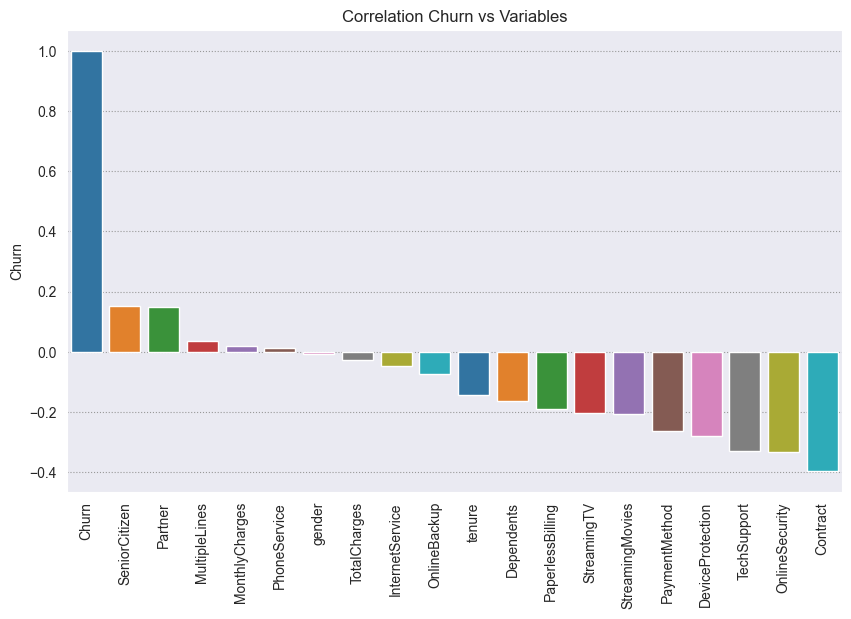

In [104]:
# Correlación del Churn vs otras variables
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()['Churn'].sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(corr, palette='tab10')
plt.xticks(rotation=90)
plt.title('Correlation Churn vs Variables')
plt.show()

### Churn

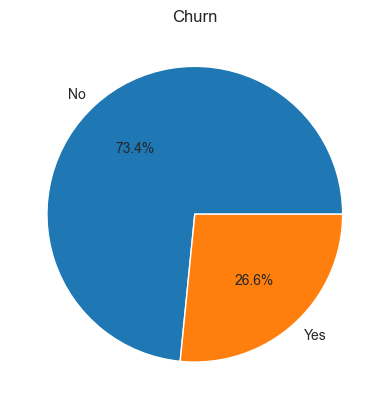

In [105]:
churn = df['Churn'].value_counts(normalize=True).reset_index(name='percentage')
plt.pie(churn['percentage'], labels=churn['Churn'], autopct='%1.1f%%')
plt.title('Churn')
plt.show()

- En lineas generales podemos observar que existe un 26,6% de clientes que rescinden los contratos con nosotros.

### Gender

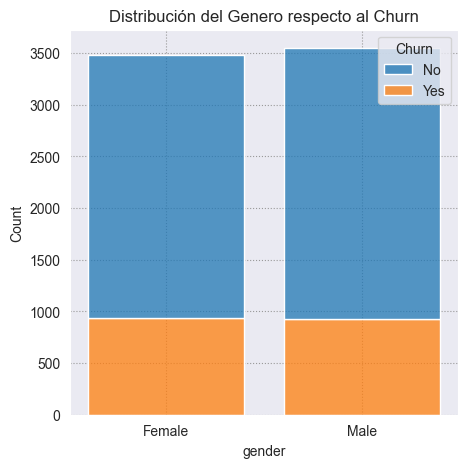

In [106]:
plt.figure(figsize=(5,5))
sns.histplot(data=df, x='gender', shrink=0.8, hue='Churn', multiple='stack')
plt.title('Distribución del Genero respecto al Churn')
plt.show()

- No existe una diferencia considerable en el genero a la hora de decidir si rescinde o no del contrato. 

### SeniorCitizen

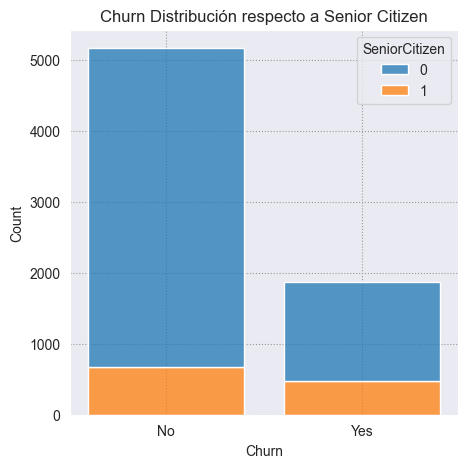

In [107]:
plt.figure(figsize=(5,5))
sns.histplot(data=df, x='Churn', hue='SeniorCitizen', shrink = 0.8, stat='count', multiple='stack')
plt.title('Churn Distribución respecto a Senior Citizen')
plt.show()

- El grupo de `SeniorCitizen` es muy bajo y dentro de los que rescinden el contrato son ellos los que menos lo hacen. 

### Partner

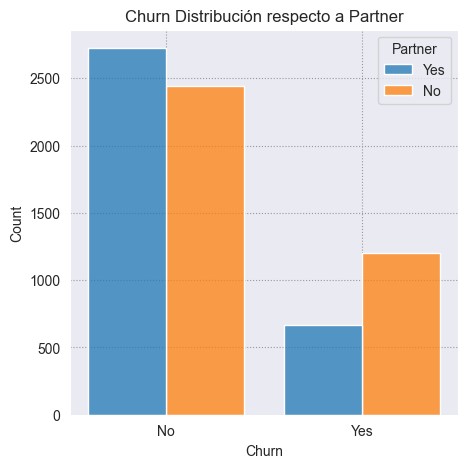

In [108]:
plt.figure(figsize=(5,5))
sns.histplot(data=df, x='Churn', hue='Partner', multiple='dodge', shrink=0.8)
plt.title('Churn Distribución respecto a Partner')
plt.show()

- Los clientes que no tienen pareja son mas propensos s rescindir el contrato.

### Dependents

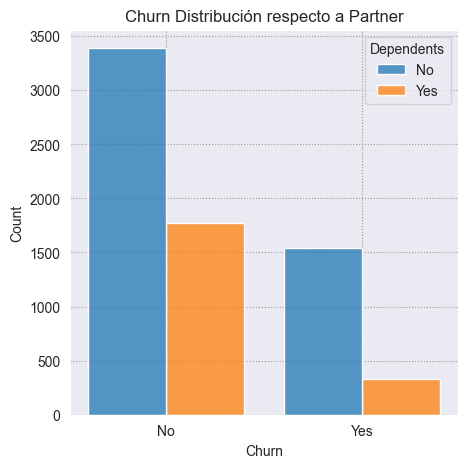

In [109]:
plt.figure(figsize=(5,5))
sns.histplot(data=df, x='Churn', hue='Dependents', multiple='dodge', shrink=0.8)
plt.title('Churn Distribución respecto a Partner')
plt.show()

- Los clientes sin dependientes son los mas propensos a rescindir.

### InternetService

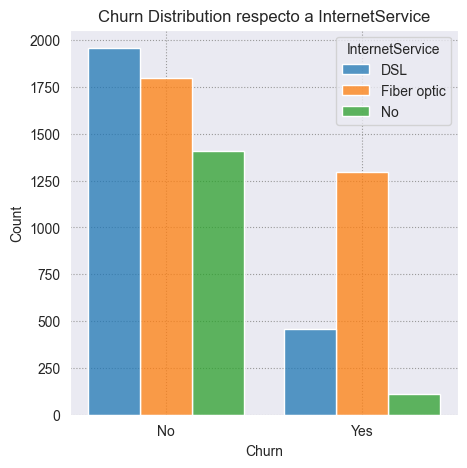

In [110]:
plt.figure(figsize=(5,5))
sns.histplot(data=df, x='Churn', hue='InternetService', multiple='dodge', shrink=0.8)
plt.title('Churn Distribution respecto a InternetService')
plt.show()

- Independientemente del genero del Cliente hay una gran mayoría que contrata el servicio de Fobra Óptica y son estos mismos los que mas rescinden los contratos.

### OnlineSecurity

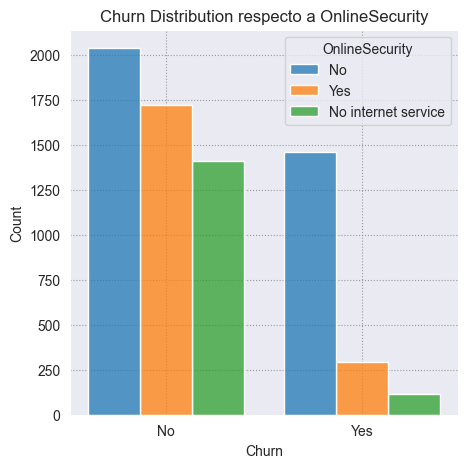

In [111]:
plt.figure(figsize=(5,5))
sns.histplot(data=df, x='Churn', hue='OnlineSecurity', multiple='dodge', shrink=0.8)
plt.title('Churn Distribution respecto a OnlineSecurity')
plt.show()

- La mayoría de los clientes que rescinden el contrato no tienen Seguridad Online.

### TechSupport

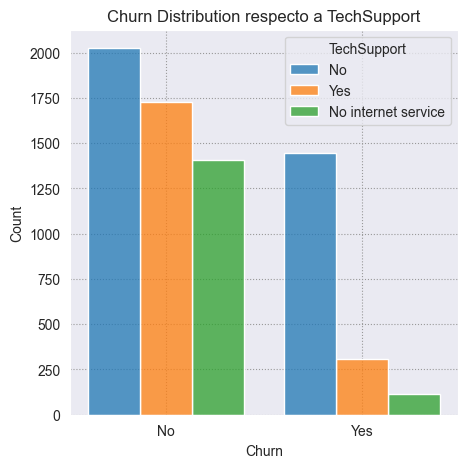

In [112]:
plt.figure(figsize=(5,5))
sns.histplot(data=df, x='Churn', hue='TechSupport', multiple='dodge', shrink=0.8)
plt.title('Churn Distribution respecto a TechSupport')
plt.show()

- La mayoría de clientes que rescinden su contrato no cuentan con soporte tecnológico.

### Tenure_Category

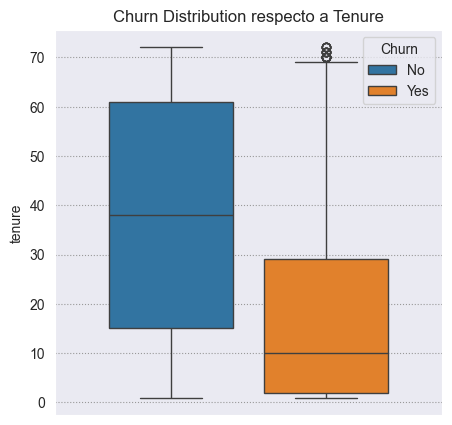

In [113]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df, hue='Churn', y='tenure', gap=0.2)
plt.title('Churn Distribution respecto a Tenure')
plt.show()

- Los nuevos clientes son los mas propensos en rescindir el contrato.

### Tenure by Contract

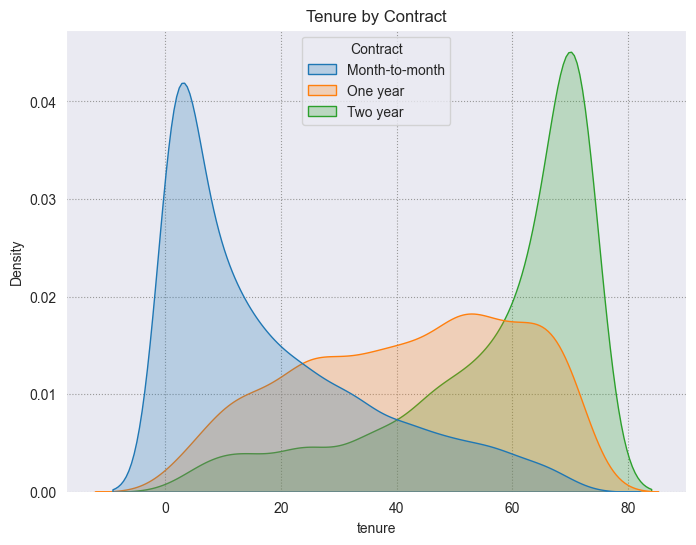

In [114]:
plt.figure(figsize=(8,6))
sns.kdeplot(data= df, x='tenure', hue='Contract', common_norm=False, fill=True)
plt.title('Tenure by Contract')
plt.show()

- En su mayoría los contratos mensuales duran poco tiempo como clientes .

### MonthlyCharges

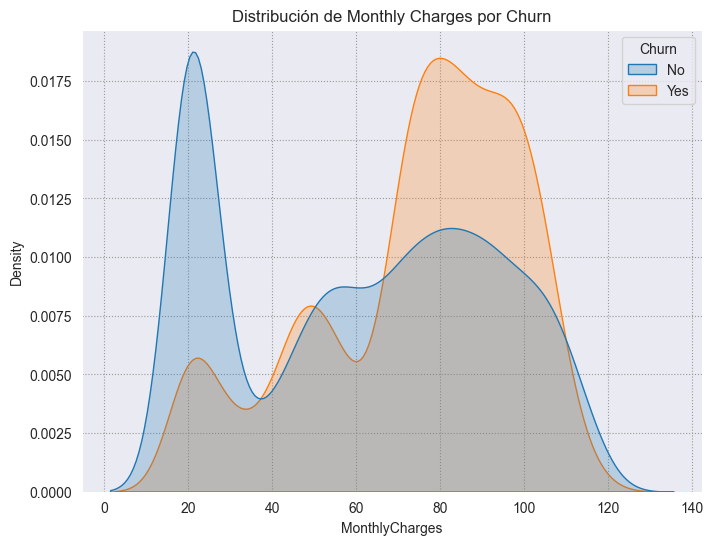

In [115]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', common_norm=False, fill=True)
plt.title('Distribución de Monthly Charges por Churn')
plt.show()

- Los clientes con altos cargos mensuales tienden de rescindir el contrato.

### TotalCharges

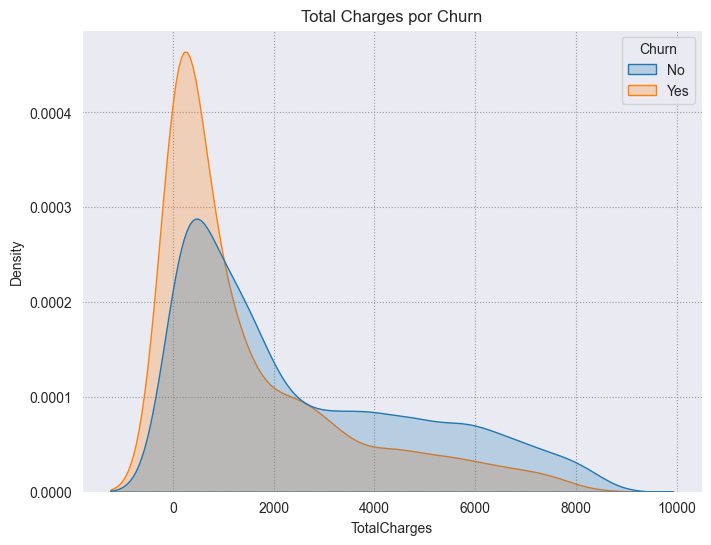

In [116]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', common_norm=False, fill=True)
plt.title('Total Charges por Churn')
plt.show()

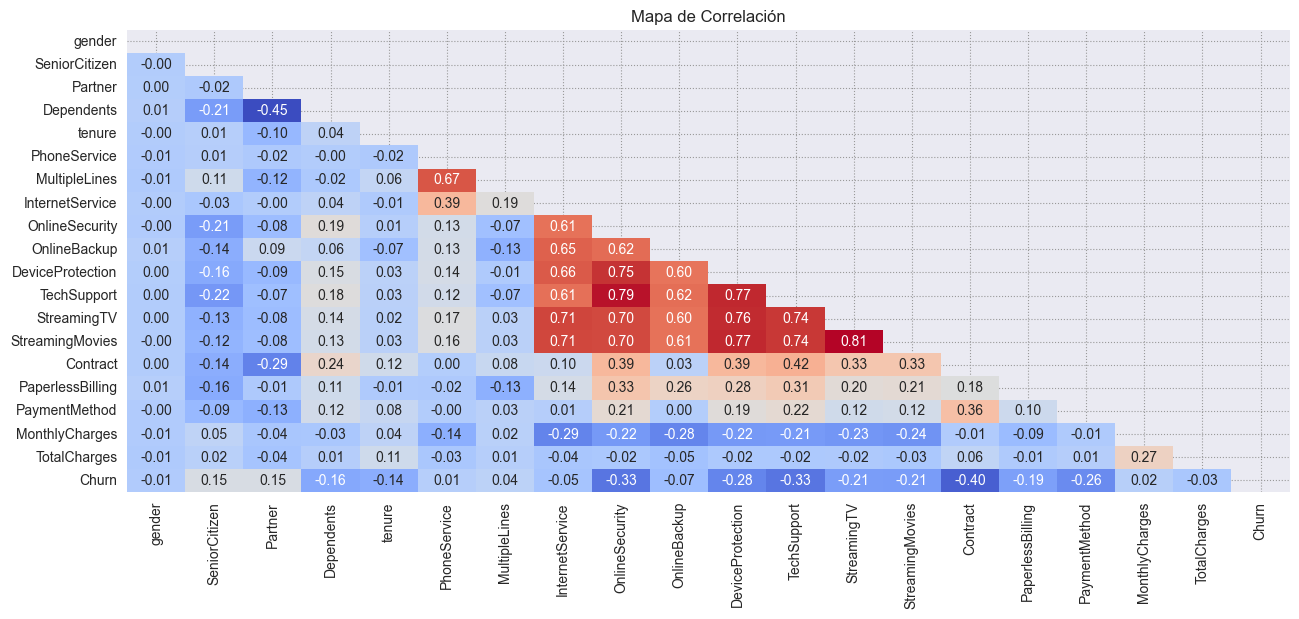

In [117]:
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(15,6))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, cbar=False, fmt='.2f')
plt.title('Mapa de Correlación')
plt.show()

## 3. Pre Processing

In [118]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

In [119]:
# Recategorizamos Churn
df['Churn'] = df['Churn'].map({'No':0, 'Yes':1})

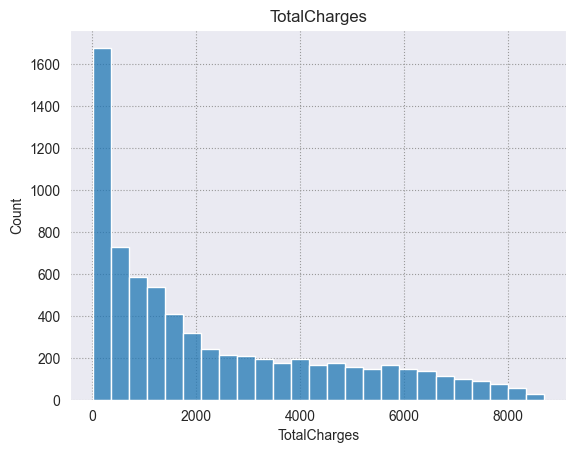

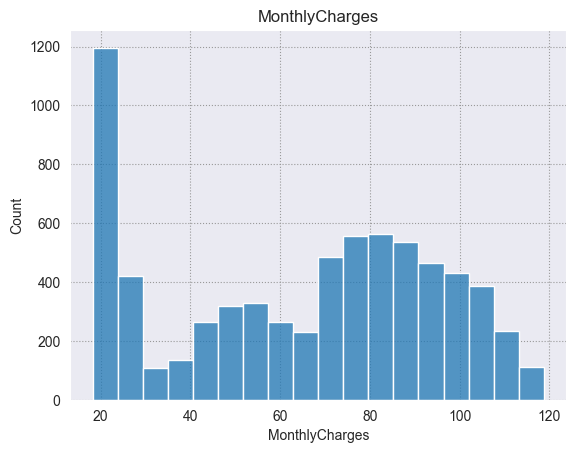

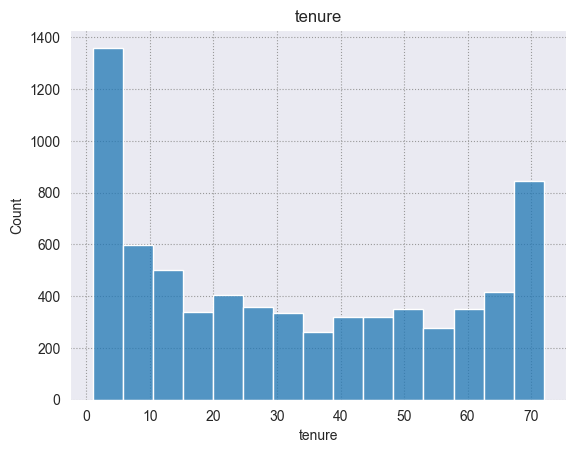

In [120]:
for col in ['TotalCharges', 'MonthlyCharges', 'tenure']:
    sns.histplot(data=df[col])
    plt.title(f'{col}')
    plt.show()

- Debido a que las variables numéricas no siguen una distribución gaussiana, usaremos PowerTransformer para acercarlas a la distribución normal.

In [121]:
# Configuramos los transformadores para las columnas
col_transformers = ColumnTransformer([
    ('sc', StandardScaler(), ['MonthlyCharges', 'TotalCharges', 'tenure']),
    ('binary', OneHotEncoder(drop='if_binary'), ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']),
    ('enc_1', OneHotEncoder(drop='first'), ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']),
('enc_2', OneHotEncoder(),['Contract', 'PaymentMethod'])
])

## 4. Modelamiento

In [122]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [123]:
# Definimos X e y
X = df.drop(columns=['Churn'])
y = df[['Churn']]

In [124]:
# Creamos los modelos a evaluar
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LD', LinearDiscriminantAnalysis()))
models.append(('DT', DecisionTreeClassifier(random_state=seed)))
models.append(('GB', GaussianNB()))
models.append(('RF', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))
models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('LGB', LGBMClassifier(random_state=seed, force_row_wise=True, verbose=-1)))

In [125]:
# Iteramos
names = []
results = []

for model_name, model in models:
    #Creamos el pipeline
    pipeline = Pipeline([
        ('transformadores', col_transformers),
        ('modelo', model)
    ])

    #Configuramos el KFold
    cv = KFold(n_splits=20, shuffle=True, random_state=seed)

    #Configuramos la validacion cruzada
    scores = cross_val_score(pipeline, X,y, cv=cv, scoring='accuracy')

    #Almacenamos los resultados
    names.append(model_name)
    results.append(scores)

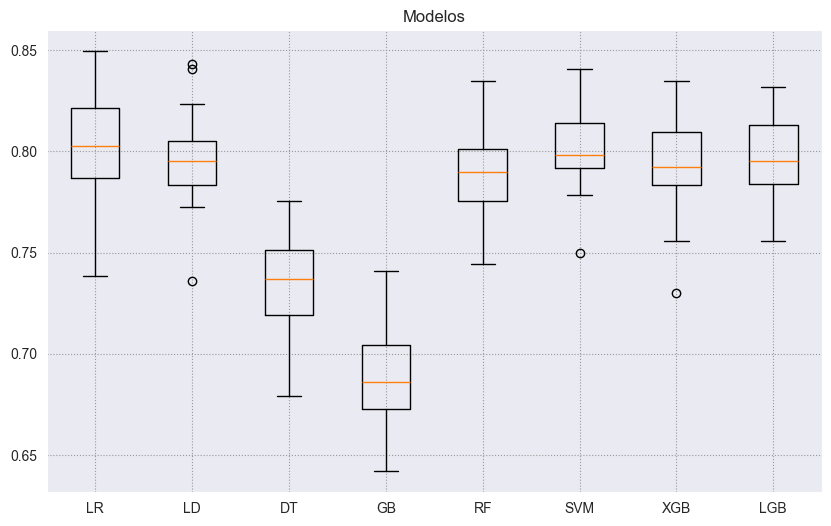

In [126]:
# Visualizando resultados
plt.figure(figsize=(10,6))
plt.boxplot(results)
plt.xticks(range(1,len(names)+1), names)
plt.title('Modelos')
plt.show()

- Consideraremos `LR`, `LD`, `RF`, `SVM`, `XGB` y `LGB`.

In [128]:
# Dividimos X e y en train y test para los modelos posteriores
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [129]:
y_train.value_counts(normalize=True)

Churn
0        0.734222
1        0.265778
Name: proportion, dtype: float64

In [130]:
y_test.value_counts(normalize=True)

Churn
0        0.734186
1        0.265814
Name: proportion, dtype: float64

### 4.1 Logistic Regression

In [131]:
# Running LogisticRegression
lr_model = LogisticRegression(random_state=seed)
pipeline_LR = Pipeline([
    ('transformadores', col_transformers),
    ('model', lr_model)
])

# Entrenamos
pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model', LogisticRegression(random_state=42))])

In [132]:
metricas(pipeline_LR, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.804622,0.658400,0.550502
Test,0.803838,0.648485,0.572193


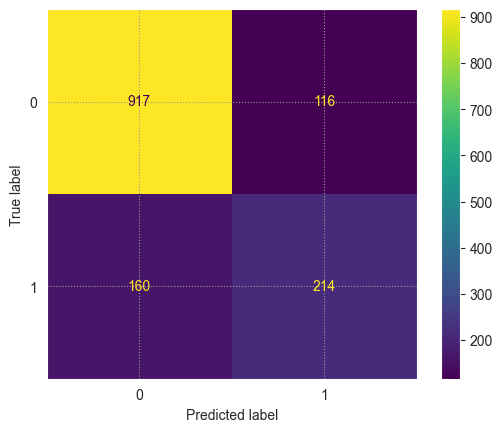

In [133]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_LR.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

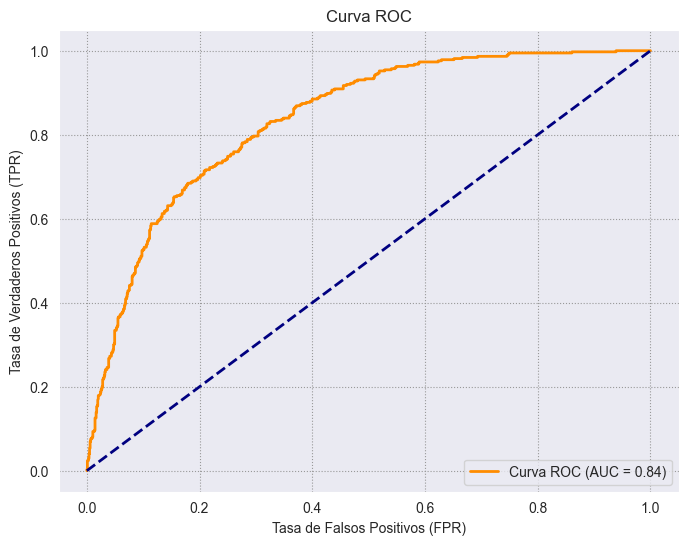

In [134]:
# Curva ROC Logistic Regression
curva_roc(pipeline_LR, X_test, y_test)

### 4.2 Linear Discrimination Analysis

In [135]:
# Running LDA Model
lda_model =  LinearDiscriminantAnalysis()
pipeline_LDA = Pipeline([
    ('transformadores', col_transformers),
    ('model', lda_model)
])

# Entrenamos el Modelo
pipeline_LDA.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model', LinearDiscriminantAnalysis())])

In [136]:
# Metricas
metricas(pipeline_LDA, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.800356,0.642638,0.560535
Test,0.791756,0.618768,0.564171


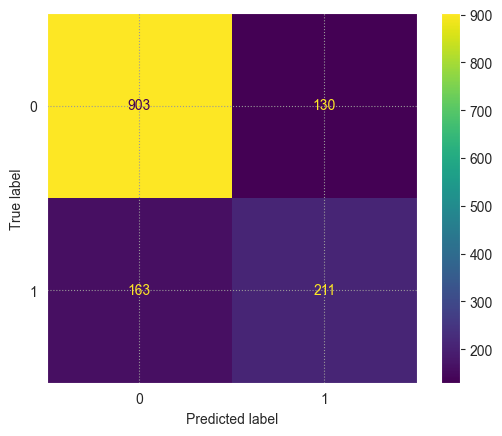

In [137]:
# Matriz de Confusion
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_LDA.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

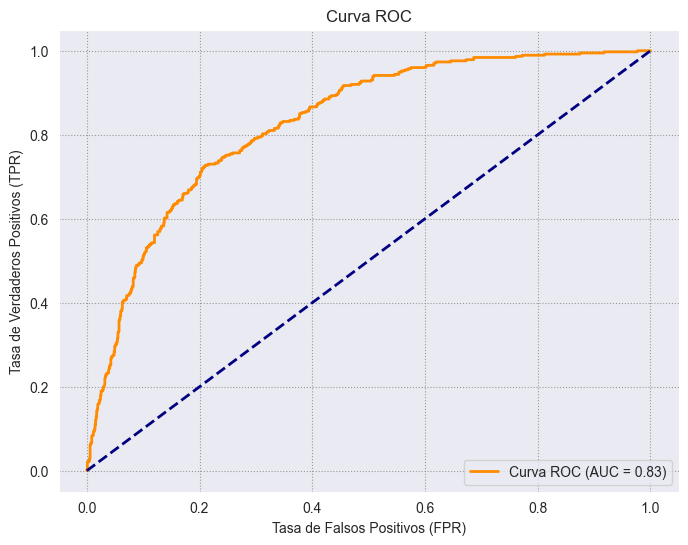

In [138]:
# Curva Roc LDA
curva_roc(pipeline_LDA, X_test, y_test)

### 4.3 Random Forest

In [139]:
# Running Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=1000,
    oob_score=True,
    random_state=seed,
    max_leaf_nodes=30,
    criterion='gini',
    min_samples_split=4)

pipeline_RF = Pipeline([
    ('transformadores', col_transformers),
    ('model', rf_model)
])

# Entrenando el Modelo
pipeline_RF.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model',
                 RandomForestClassifier(max_leaf_nodes=30, min_samples_split=4,
                                        n_estimators=1000, oob_score=True,
                                        random_state=42))])

In [140]:
# Metricas
metricas(pipeline_RF, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.818844,0.717153,0.525753
Test,0.786070,0.633700,0.462567


In [141]:
X_col = col_transformers.get_feature_names_out().tolist()
X_col = [x.replace('pt__', '').replace('binary__', '').replace('enc_1__', '').replace('enc_2__', '') for x in X_col]

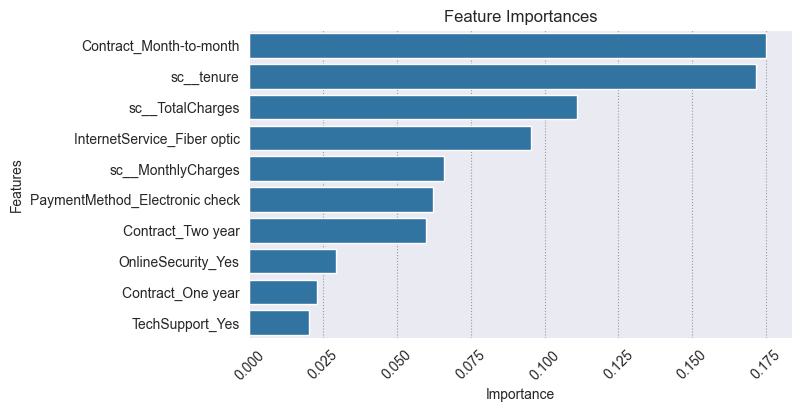

In [142]:
importance_features =   pd.DataFrame(zip( X_col,pipeline_RF.named_steps['model'].feature_importances_),
                        columns=['Features','Importance']).sort_values(by='Importance', ascending=False)

#Graficamos las Variables
plt.figure(figsize=(7,4))
sns.barplot(x='Importance', y='Features', data=importance_features[:10])
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

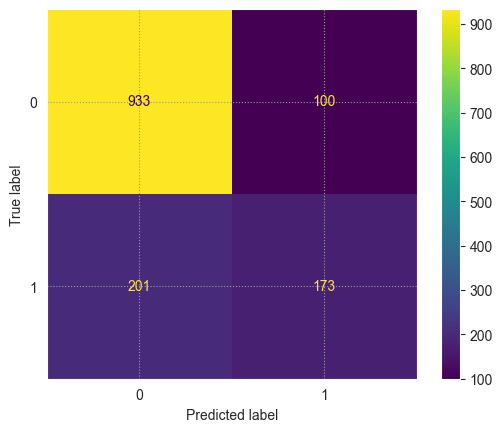

In [143]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_RF.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

### 4.4 Support Vector Machine

In [144]:
# Running SVC Model
svm_model = SVC(random_state=seed, kernel='poly', probability=True)
pipeline_SVM = Pipeline([
    ('transformadores', col_transformers),
    ('model', svm_model)
])

# Entrenando el modelo
pipeline_SVM.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model',
                 SVC(kernel='poly', probability=True, random_state=42))])

In [145]:
# Metricas
metricas(pipeline_SVM, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.819022,0.729107,0.507692
Test,0.788202,0.643939,0.454545


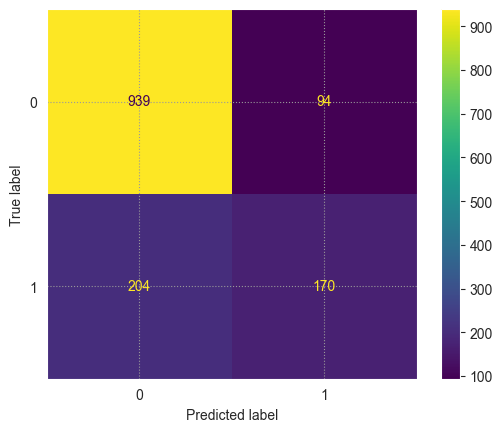

In [146]:
# Confusion Matrix
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_SVM.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

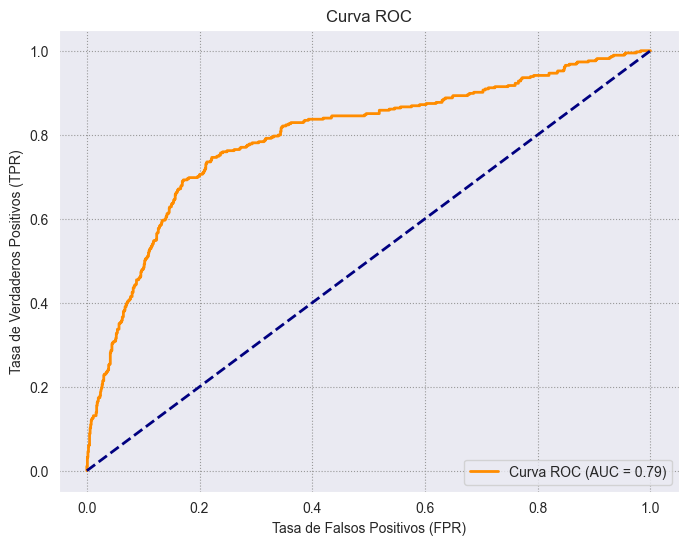

In [147]:
# Curva ROC
curva_roc(pipeline_SVM, X_test, y_test)

### 4.5 XGB

In [148]:
# Running XGB Model
xgb_model = XGBClassifier(
    random_state=seed,
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.01,
    booster='dart')

pipeline_XGB = Pipeline([
    ('transformadores', col_transformers),
    ('model', xgb_model)
])

# Entrenamos el Modelo
pipeline_XGB.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [149]:
# Metricas
metricas(pipeline_XGB, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.818844,0.698333,0.560535
Test,0.798152,0.638889,0.553476


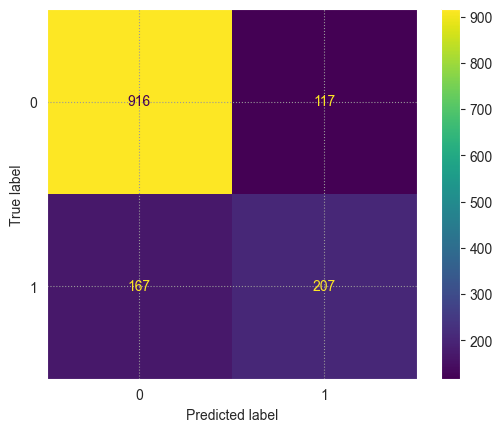

In [150]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_XGB.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

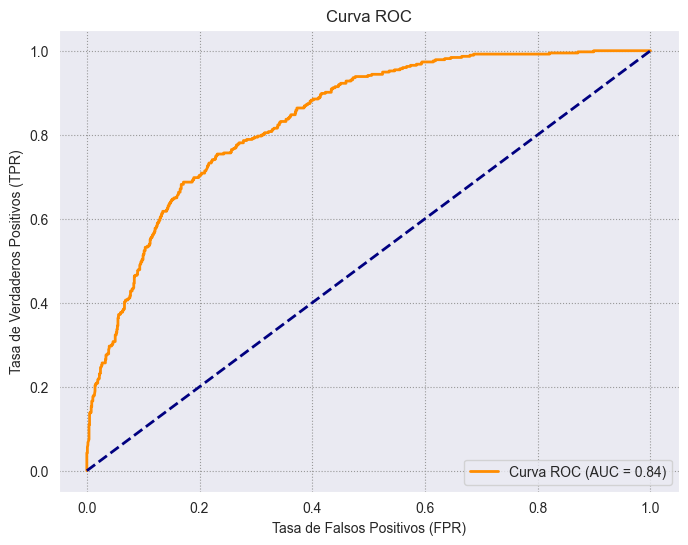

In [151]:
curva_roc(pipeline_XGB, X_test, y_test)

### 4.6 LGB

In [152]:
# Running LGB Model
lgb_model = LGBMClassifier(
    random_state=seed,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=1000)

pipeline_LGB = Pipeline([
    ('transformadores', col_transformers),
    ('model', lgb_model)
])

# Entrenamos el modelo
pipeline_LGB.fit(X_train, y_train)


Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.01, max_depth=3,
                                n_estimators=1000, random_state=42))])

In [153]:
# Metricas
metricas(pipeline_LGB, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.822044,0.705491,0.567224
Test,0.796731,0.638365,0.542781


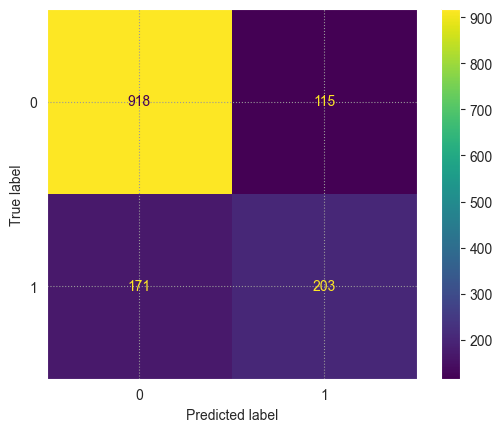

In [154]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_LGB.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

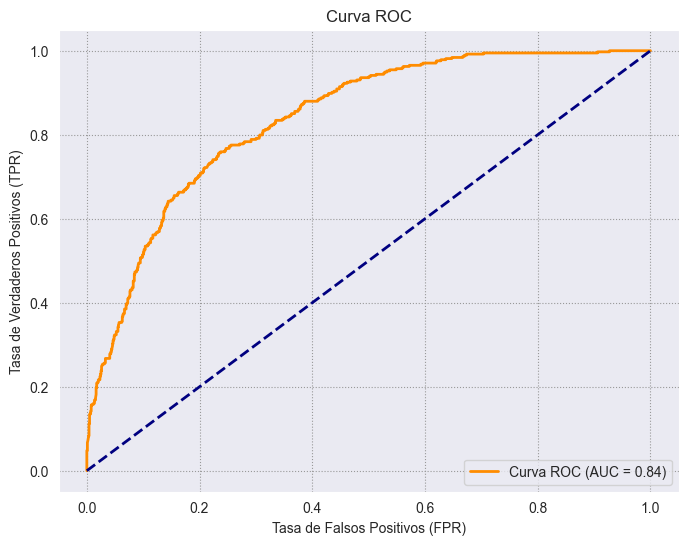

In [155]:
curva_roc(pipeline_LGB, X_test, y_test)

### 4.7 Stacking Classifier

In [156]:
from sklearn.ensemble import StackingClassifier

In [161]:
# Stacking Models
estimators = [
    ('LR', lr_model),
    ('LDA', lda_model),
    ('SVM', svm_model),
    ('XGB', xgb_model),
    ('LGB', lgb_model)
]

pipeline_stack = Pipeline([
    ('transformadores', col_transformers),
    ('stacking', StackingClassifier(
        estimators=estimators,
        final_estimator=lr_model
    ))
])

# Entrenamos el Modelo
pipeline_stack.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',...
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=3,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)),
                                                ('LGB',
                                                 LGBMClassifier(learning_rate=0.01,
                                                                max_depth=3,
                                                                n_estimators=1000,
                                                                random_state=42))],
                                    final_estimator=LogisticRegression(random_state=42)))])

In [162]:
# Metricas
metricas(pipeline_stack, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.811556,0.674699,0.561873
Test,0.805970,0.650746,0.582888


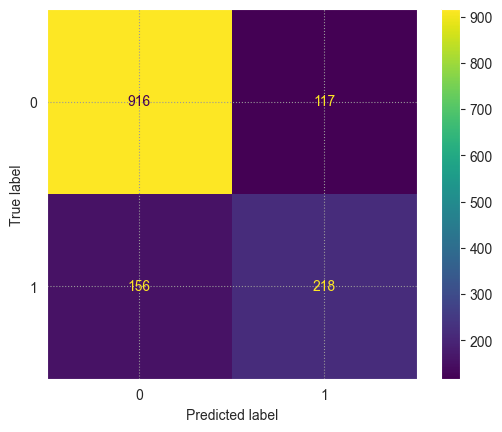

In [163]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_stack.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

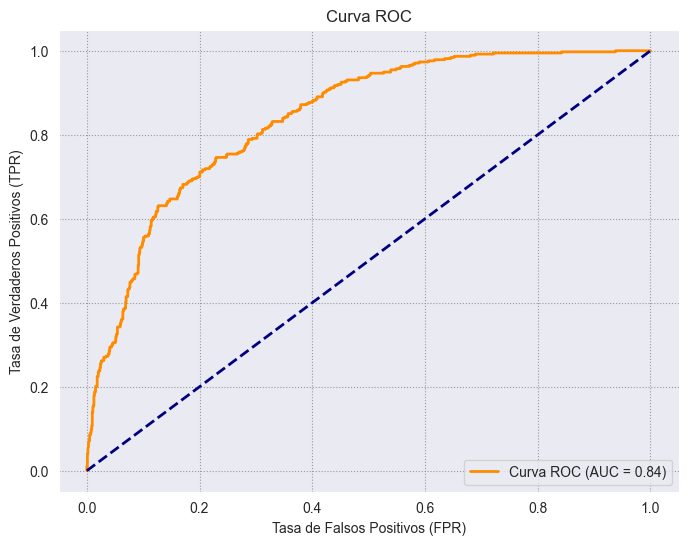

In [164]:
curva_roc(pipeline_stack, X_test, y_test)

### 4.8 Voting Classifier

In [165]:
from sklearn.ensemble import VotingClassifier

In [166]:
# Voting Classifier
estimators = [
    ('LR', lr_model),
    ('LDA', lda_model),
    ('SVM', svm_model),
    ('XGB', xgb_model),
    ('LGB', lgb_model)
]

# Creamos el pipeline
pipeline_voting = Pipeline([
    ('transformadores', col_transformers),
    ('estimator', VotingClassifier(
        estimators=estimators, voting='soft'))
])

# Entrenando el Modelo
pipeline_voting.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',...
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=1000,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('LGB',
                                               LGBMClassifier(learning_rate=0.01,
                                                              max_depth=3,
                                                              n_estimators=1000,
                                                              random_state=42))],
                                  voting='soft'))])

In [167]:
# Metricas
metricas(pipeline_voting, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.816356,0.701923,0.537124
Test,0.801706,0.658863,0.526738


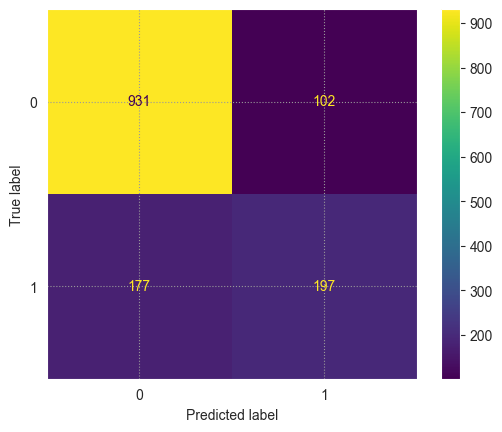

In [169]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_voting.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

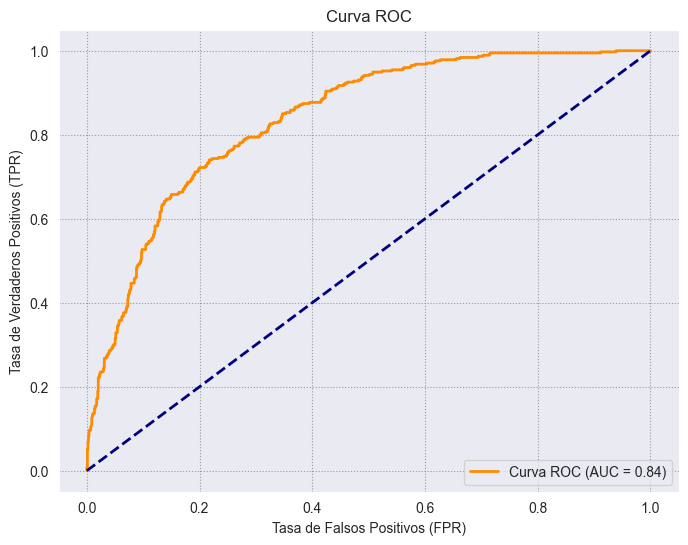

In [170]:
curva_roc(pipeline_voting, X_test, y_test)

## 5. Final Model

In [171]:
metricas(pipeline_stack, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.811556,0.674699,0.561873
Test,0.805970,0.650746,0.582888


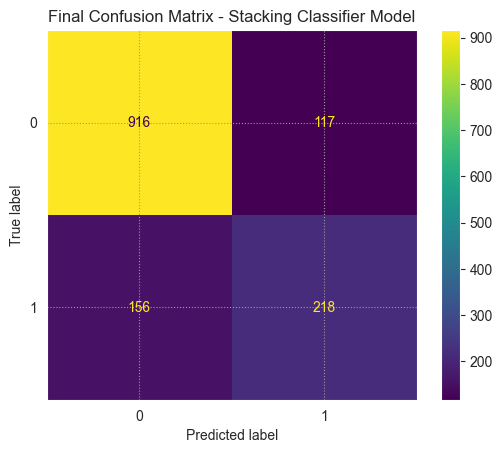

In [175]:
# Final ConfusionMatrix
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_stack.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('Final Confusion Matrix - Stacking Classifier Model')
plt.show()

**1. Interpretación del Accuracy y el Recall**
- Accuracy (81%): Este porcentaje indica que el modelo predice correctamente si un cliente se va o se queda en el 81% de los casos. Aunque es un buen indicador, en problemas de churn el recall suele ser aún más importante.
- Recall (58%): El recall mide la capacidad del modelo para identificar correctamente los clientes que efectivamente harán churn. Un 58% significa que de todos los clientes que realmente se irían, el modelo está identificando correctamente a más de la mitad, aunque aún hay margen de mejora.

**2. Importancia de Recall en Churn**
- En problemas de churn, el recall es crucial porque queremos captar a los clientes en riesgo de irse para poder tomar acciones preventivas. Aumentar el recall, aunque afecte ligeramente al accuracy, puede ser beneficioso en estos casos.